In [38]:
import psycopg2
import pandas as pd
from tqdm import tqdm
import json
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Adjust width to avoid line wrapping
pd.set_option('display.max_colwidth', None)  # Display full content in each cell

In [29]:

host = "localhost"
port = "5432"

# PostgreSQL credentials
user = "tanmay"
password = "pass_postgre1"
database = "mimic4_clinical_demo"

# Connect to PostgreSQL
try:
    conn = psycopg2.connect(
        host=host,
        port=port,
        user=user,
        password=password,
        dbname=database
    )
    print("PSQL Connection successful!")
except Exception as e:
    print(f"Error connecting to database: {e}")

PSQL Connection successful!


In [30]:
# Execute Query
def exec_query(query):
    try:
        # Establish the connection
        conn = psycopg2.connect(
        host=host,
        port=port,
        user=user,
        password=password,
        dbname=database
        )
        cursor = conn.cursor()
        # Execute the query
        cursor.execute(query)
        # Fetch column names from the cursor
        colnames = [desc[0] for desc in cursor.description]
        # Fetch all rows of the query
        results = cursor.fetchall()
        # Create a DataFrame with column names
        df = pd.DataFrame(results, columns=colnames)
        # Close the cursor and connection
        cursor.close()
        conn.close()
        # Return the DataFrame
        return df

    except Exception as e:
        print(f"Error executing query: {e}")
        # Roll back the transaction in case of error
        conn.rollback()
        cursor.close()
        conn.close()
        return None

# 1: Extract Bed Occupancy & ICU Data from PostgreSQL
We need to extract admission and discharge timestamps, along with ICU stays.
Modify your SQL query function to retrieve this data.

In [31]:
# Query to fetch ICU admissions, discharge, and bed occupancy data
query = """
SELECT 
    admission.hadm_id, 
    admission.subject_id, 
    admission.admittime, 
    admission.dischtime, 
    icu.stay_id, 
    icu.intime AS icu_admit_time, 
    icu.outtime AS icu_discharge_time
FROM admissions AS admission
LEFT JOIN icustays AS icu 
ON admission.hadm_id = icu.hadm_id
"""

# Execute the query and store the result in a dataframe
icu_df = exec_query(query)

# Display the first few rows
icu_df.head()


,hadm_id,subject_id,admittime,dischtime,stay_id,icu_admit_time,icu_discharge_time
0,25926192,10009628,2153-09-17 17:08:00,2153-09-25 13:20:00,35258379,2153-09-19 09:54:49,2153-09-21 16:39:06
1,23983182,10018081,2134-08-18 02:02:00,2134-08-23 19:35:00,None,None,None
2,22942076,10006053,2111-11-13 23:39:00,2111-11-15 17:20:00,32895909,2111-11-13 23:40:00,2111-11-14 00:14:10
3,22942076,10006053,2111-11-13 23:39:00,2111-11-15 17:20:00,34617352,2111-11-14 00:19:12,2111-11-15 18:21:10
4,21606243,10031404,2113-08-04 18:46:00,2113-08-06 20:57:00,35544374,2113-08-04 18:47:42,2113-08-05 23:45:02


# 2: Data Preprocessing & Feature Engineering

### Convert timestamps & Calculate Stay Durations
Modify your code to clean and preprocess timestamps:

In [32]:
# Convert timestamps to datetime format
icu_df['admittime'] = pd.to_datetime(icu_df['admittime'])
icu_df['dischtime'] = pd.to_datetime(icu_df['dischtime'])
icu_df['icu_admit_time'] = pd.to_datetime(icu_df['icu_admit_time'])
icu_df['icu_discharge_time'] = pd.to_datetime(icu_df['icu_discharge_time'])

# Calculate Length of Stay (LOS) in days
icu_df['hospital_los'] = (icu_df['dischtime'] - icu_df['admittime']).dt.total_seconds() / (24 * 3600)
icu_df['icu_los'] = (icu_df['icu_discharge_time'] - icu_df['icu_admit_time']).dt.total_seconds() / (24 * 3600)

# Fill ICU stay with 0 if the patient was never admitted to ICU
icu_df['icu_los'] = icu_df['icu_los'].fillna(0)

# Display processed data
display(icu_df[['admittime', 'dischtime', 'hospital_los', 'icu_los']].head())


,admittime,dischtime,hospital_los,icu_los
0,2153-09-17 17:08:00,2153-09-25 13:20:00,7.841667,2.280752
1,2134-08-18 02:02:00,2134-08-23 19:35:00,5.731250,0.000000
2,2111-11-13 23:39:00,2111-11-15 17:20:00,1.736806,0.023727
3,2111-11-13 23:39:00,2111-11-15 17:20:00,1.736806,1.751366
4,2113-08-04 18:46:00,2113-08-06 20:57:00,2.090972,1.206481


### Create ICU Bed Occupancy Trends
To forecast ICU occupancy, we need to count ICU patients per day.

In [33]:
# Create a daily ICU occupancy trend
icu_stay_events = []

for index, row in icu_df.iterrows():
    if pd.notnull(row['icu_admit_time']):
        icu_stay_events.append({'date': row['icu_admit_time'].date(), 'count': 1})  # Admission
    if pd.notnull(row['icu_discharge_time']):
        icu_stay_events.append({'date': row['icu_discharge_time'].date(), 'count': -1})  # Discharge

# Convert to DataFrame
icu_trend_df = pd.DataFrame(icu_stay_events)

# Aggregate daily ICU occupancy
icu_trend_df = icu_trend_df.groupby('date').sum().cumsum().reset_index()

# Display ICU trend data
display(icu_trend_df.head())


,date,count
0,2110-04-11,1
1,2110-04-12,0
2,2110-11-30,1
3,2110-12-05,0
4,2111-01-17,1


# 3: Exploratory Data Analysis (EDA)

### Plot ICU Occupancy Trends

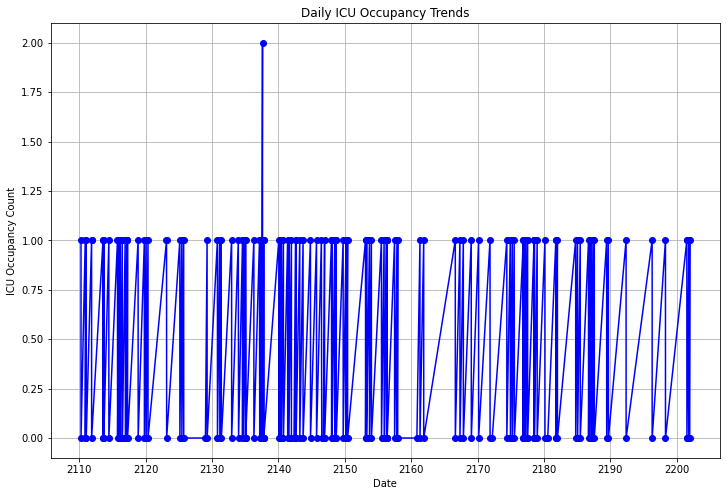

In [34]:
import matplotlib.pyplot as plt

# Plot ICU bed occupancy trend
plt.figure(figsize=(12, 8))
plt.plot(icu_trend_df['date'], icu_trend_df['count'], marker='o', linestyle='-', color='b')
plt.xlabel("Date")
plt.ylabel("ICU Occupancy Count")
plt.title("Daily ICU Occupancy Trends")
plt.grid(True)
plt.show()


### Check Hospital LOS Distribution

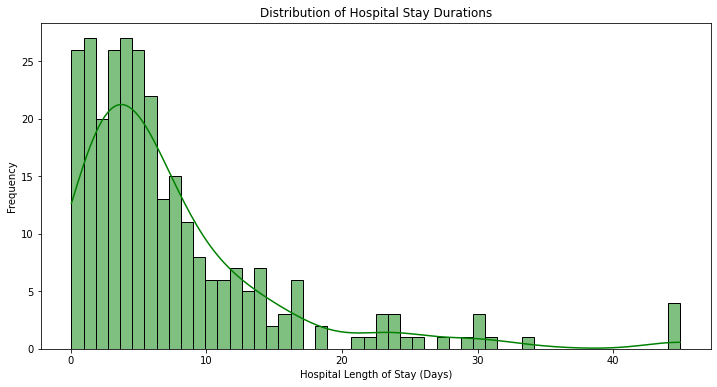

In [35]:
import seaborn as sns

# Plot distribution of hospital LOS
plt.figure(figsize=(12, 6))
sns.histplot(icu_df['hospital_los'], bins=50, kde=True, color='g')
plt.xlabel("Hospital Length of Stay (Days)")
plt.ylabel("Frequency")
plt.title("Distribution of Hospital Stay Durations")
plt.show()


###  Identify Trends & Seasonality

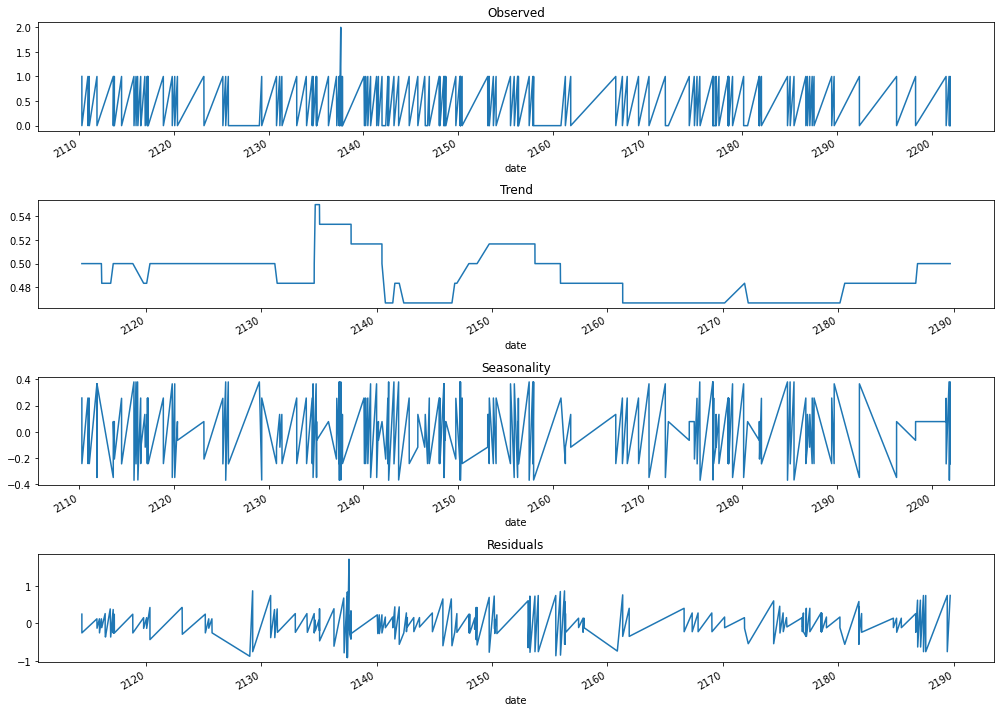

In [36]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Decompose time series for trend analysis
icu_trend_df.set_index("date", inplace=True)
icu_trend_df.index = pd.to_datetime(icu_trend_df.index)
decomposition = sm.tsa.seasonal_decompose(icu_trend_df['count'], model='additive', period=30)

# Increase figure size
fig, axes = plt.subplots(4, 1, figsize=(14, 10))  # Adjust width and height
decomposition.observed.plot(ax=axes[0], title='Observed')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonality')
decomposition.resid.plot(ax=axes[3], title='Residuals')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


# 4: Train a SARIMA Model

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ensure datetime index
icu_trend_df.index = pd.to_datetime(icu_trend_df.index)

# Split data (80% train, 20% test)
train_size = int(len(icu_trend_df) * 0.8)
train, test = icu_trend_df.iloc[:train_size], icu_trend_df.iloc[train_size:]

# Fit SARIMA model
model = SARIMAX(train['count'], order=(2,1,2), seasonal_order=(1,1,1,30))
sarima_result = model.fit(disp=False)

# Forecast
forecast_steps = len(test)  # Forecast for test period
forecast = sarima_result.get_forecast(steps=forecast_steps)
forecast_index = test.index
forecast_values = forecast.predicted_mean

# Evaluate performance
mae = mean_absolute_error(test['count'], forecast_values)
rmse = np.sqrt(mean_squared_error(test['count'], forecast_values))
print(f"MAE: {mae}, RMSE: {rmse}")


MAE: 0.426260347490691, RMSE: 0.5122389434763566


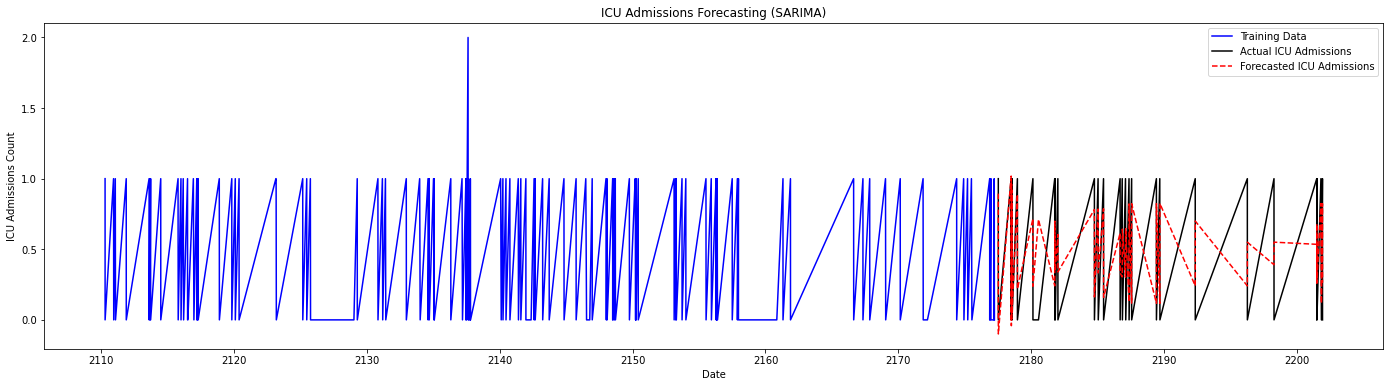

In [43]:
# Plot actual vs forecasted values
plt.figure(figsize=(24,6))
plt.plot(train.index, train['count'], label="Training Data", color='blue')
plt.plot(test.index, test['count'], label="Actual ICU Admissions", color='black')
plt.plot(forecast_index, forecast_values, label="Forecasted ICU Admissions", color='red', linestyle="dashed")
plt.title("ICU Admissions Forecasting (SARIMA)")
plt.xlabel("Date")
plt.ylabel("ICU Admissions Count")
plt.legend()
plt.show()

### Optimize SARIMA Hyperparameters

In [45]:
from pmdarima import auto_arima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ensure datetime index
icu_trend_df.index = pd.to_datetime(icu_trend_df.index)

# Split data (80% train, 20% test)
train_size = int(len(icu_trend_df) * 0.8)
train, test = icu_trend_df.iloc[:train_size], icu_trend_df.iloc[train_size:]

# Find best SARIMA parameters using auto_arima
auto_model = auto_arima(train['count'], seasonal=True, m=30, 
                        stepwise=True, trace=True, 
                        suppress_warnings=True, max_p=5, max_q=5, 
                        max_P=3, max_Q=3, max_d=2, max_D=2)

best_order = auto_model.order
best_seasonal_order = auto_model.seasonal_order
print(f"Best SARIMA Order: {best_order}, Seasonal Order: {best_seasonal_order}")

# Fit best SARIMA model
model = SARIMAX(train['count'], order=best_order, seasonal_order=best_seasonal_order)
sarima_result = model.fit(disp=False)

# Forecast
forecast_steps = len(test)
forecast = sarima_result.get_forecast(steps=forecast_steps)
forecast_index = test.index
forecast_values = forecast.predicted_mean

# Evaluate performance
mae = mean_absolute_error(test['count'], forecast_values)
rmse = np.sqrt(mean_squared_error(test['count'], forecast_values))
print(f"Improved MAE: {mae}, Improved RMSE: {rmse}")


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[30] intercept   : AIC=53.784, Time=2.18 sec
 ARIMA(0,0,0)(0,0,0)[30] intercept   : AIC=313.761, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[30] intercept   : AIC=48.298, Time=0.38 sec
 ARIMA(0,0,1)(0,0,1)[30] intercept   : AIC=173.595, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[30]             : AIC=450.094, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[30] intercept   : AIC=48.706, Time=0.01 sec
 ARIMA(1,0,0)(2,0,0)[30] intercept   : AIC=49.650, Time=2.61 sec
 ARIMA(1,0,0)(1,0,1)[30] intercept   : AIC=49.391, Time=1.06 sec
 ARIMA(1,0,0)(0,0,1)[30] intercept   : AIC=48.580, Time=0.37 sec
 ARIMA(1,0,0)(2,0,1)[30] intercept   : AIC=50.780, Time=4.75 sec
 ARIMA(0,0,0)(1,0,0)[30] intercept   : AIC=311.681, Time=0.12 sec
 ARIMA(2,0,0)(1,0,0)[30] intercept   : AIC=49.699, Time=0.50 sec
 ARIMA(1,0,1)(1,0,0)[30] intercept   : AIC=49.772, Time=0.64 sec
 ARIMA(0,0,1)(1,0,0)[30] intercept   : AIC=173.481, Time=0.36 sec
 ARIMA(2,0,1)(1,0,0)[30] intercept   : AIC

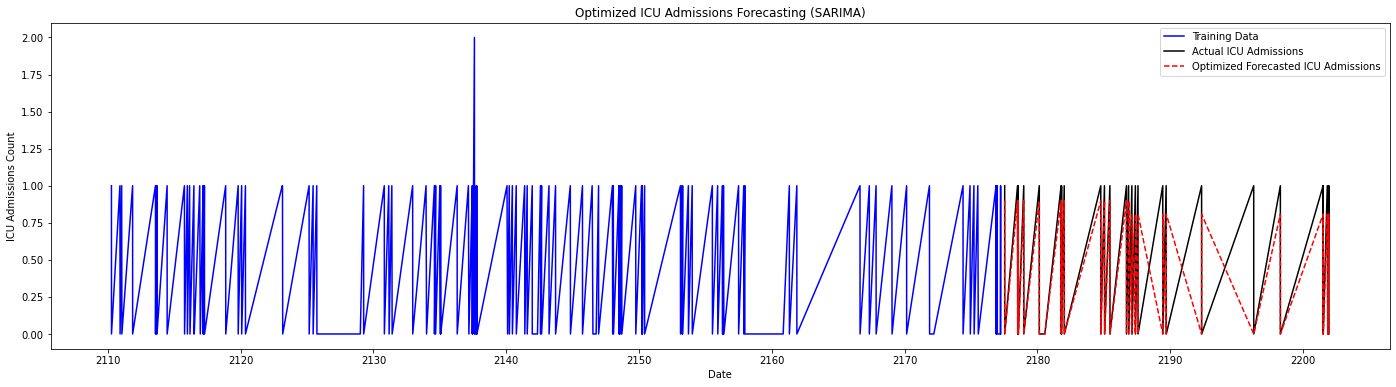

In [47]:
# Plot actual vs forecasted values
plt.figure(figsize=(24,6))
plt.plot(train.index, train['count'], label="Training Data", color='blue')
plt.plot(test.index, test['count'], label="Actual ICU Admissions", color='black')
plt.plot(forecast_index, forecast_values, label="Optimized Forecasted ICU Admissions", color='red', linestyle="dashed")
plt.title("Optimized ICU Admissions Forecasting (SARIMA)")
plt.xlabel("Date")
plt.ylabel("ICU Admissions Count")
plt.legend()
plt.show()